# Pendahuluan

Bahasa Isyarat Amerika (ASL) adalah bahasa isyarat yang memiliki sifat linguistik yang sama dengan bahasa lisan, dengan tata bahasa yang berbeda dari bahasa Inggris. ASL diekspresikan dengan gerakan tangan dan wajah. Ini adalah bahasa utama yang banyak digunakan oleh orang Amerika Utara yang tuli dan sulit mendengar. Data yang digunakan adalah data primer yang menggunakan library open-cv untuk menangkap foto tangan berdasarkan bentuk yang melambangkan huruf-huruf bahasa isyarat amerika. library cvzone digunakan untuk melakukan mapping skeleton struktur jari-jari tangan agar memudahkan model untuk membedakan karakteristik antar huruf yang mana dapat meng-improve akurasi model. Label terdiri dari huruf A-Z yang direpresentasikan dengan notasi angka (A=1, B=2, ...) kecuali huruf J dan Z dikarenakan perlu adanya pergerakkan jari dalam mengisyaratkan huruf tersebut.

![image.png](sign_mnist/amer_sign2.png)


In [281]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import seaborn as sns
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import string


In [71]:
class CONFIG:
    TRAIN_CSV_PATH = "./DATA_TRAIN_TEST/train/train.csv"
    TEST_CSV_PATH = "./DATA_TRAIN_TEST/val/test.csv"


class Colors:
    LightGray = "#fafafa"
    Teal = "#008080"
    DarkGray = "#464144"


In [72]:
train_df = pd.read_csv(CONFIG.TRAIN_CSV_PATH)
test_df = pd.read_csv(CONFIG.TEST_CSV_PATH)

In [73]:
test = pd.read_csv(CONFIG.TEST_CSV_PATH)
y = test["label"]

In [74]:
train_df.head()

,label,pixels_1,pixels_2,pixels_3,pixels_4,pixels_5,pixels_6,pixels_7,pixels_8,pixels_9,...,pixels_4087,pixels_4088,pixels_4089,pixels_4090,pixels_4091,pixels_4092,pixels_4093,pixels_4094,pixels_4095,pixels_4096
0,9,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,23,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,20,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,20,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,9,255,255,255,255,255,255,255,255,255,...,250,255,255,255,255,255,255,255,255,255


# Data Visualization


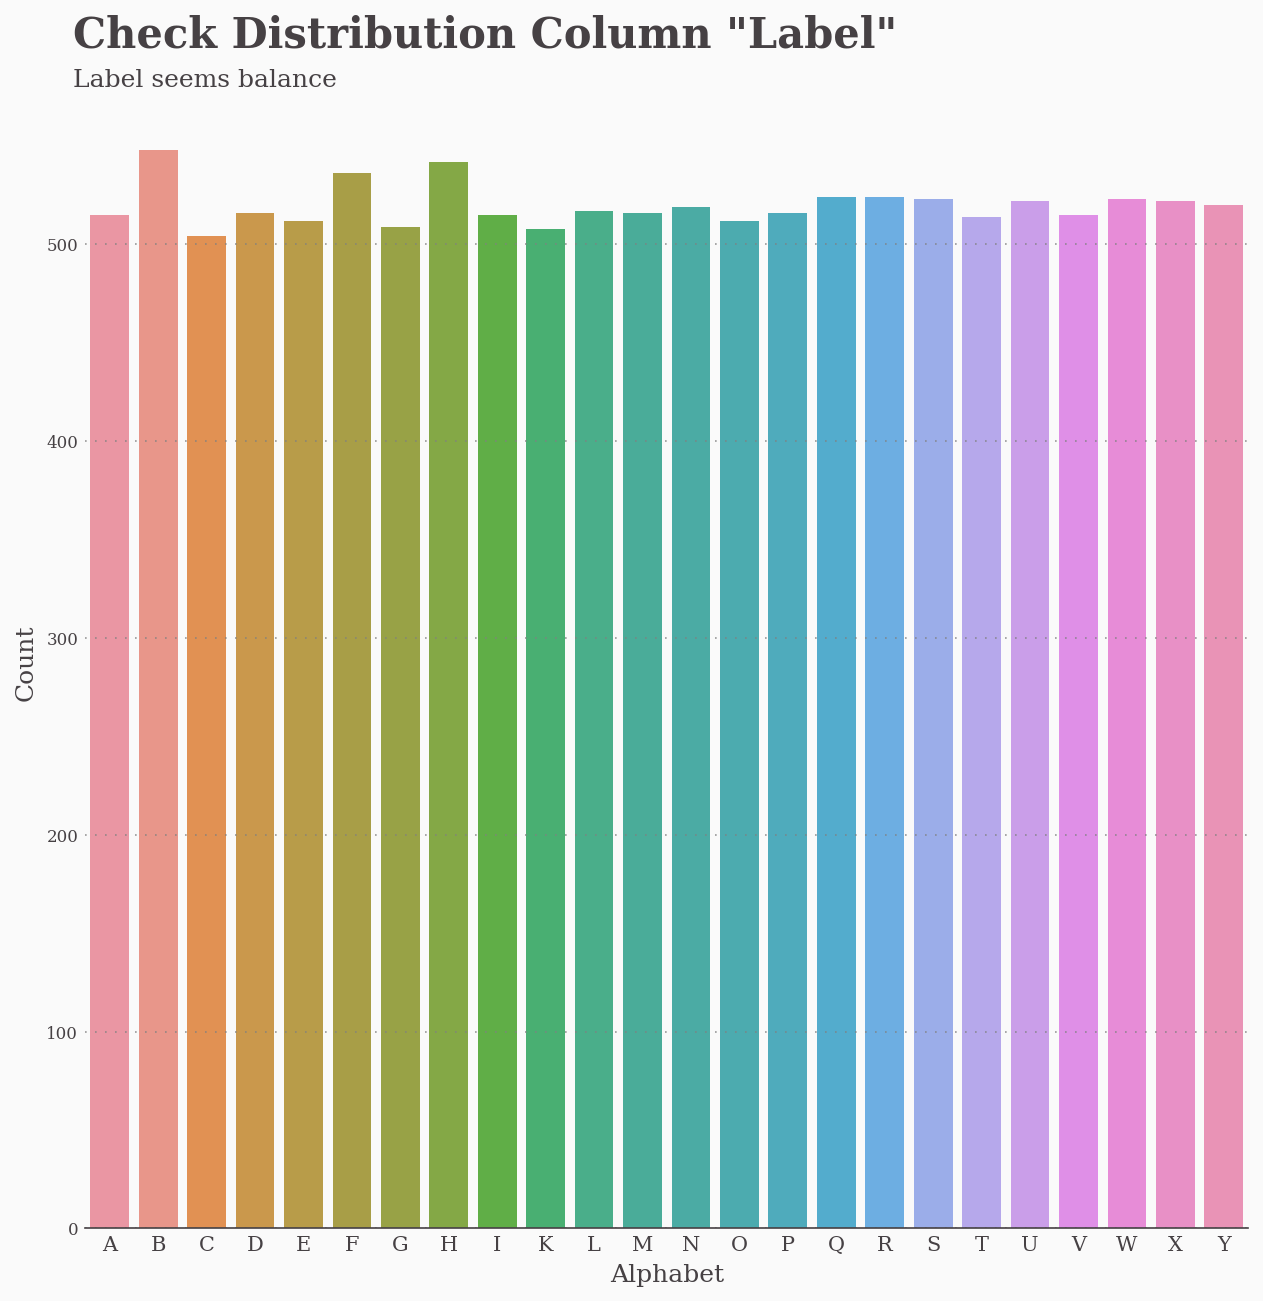

In [75]:
alphabet = list(string.ascii_uppercase)
alphabet.remove("J")
alphabet.remove("Z")

fig = plt.figure(figsize=(10, 10), dpi=150, facecolor=Colors.LightGray)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.35, hspace=0.27)
# setup axis
ax0 = fig.add_subplot(gs[0:1, 0:1])
ax0.set_facecolor(Colors.LightGray)
ax0.grid(
    which="major",
    axis="y",
    zorder=0,
    color="gray",
    linestyle=":",
    dashes=(1, 5),
    alpha=0.8,
)
ax0.tick_params(axis="both", which="both", length=0)
for sp in ["top", "right", "left"]:
    ax0.spines[sp].set_visible(False)
ax0.spines["bottom"].set_color(Colors.DarkGray)
sns.countplot(
    data=train_df,
    x="label",
    ax=ax0,
)

# plot setting
ax0.set_xticklabels(
    labels=list(alphabet),
    fontfamily="serif",
    fontsize=10,
    color=Colors.DarkGray,
)
plt.yticks(fontfamily="serif", color=Colors.DarkGray, fontsize=8)
ax0.set_xlabel("Alphabet", fontfamily="serif", fontsize=12, color=Colors.DarkGray)
ax0.set_ylabel("Count", fontfamily="serif", fontsize=12, color=Colors.DarkGray)


# text
ax0.text(
    -0.75,
    600,
    'Check Distribution Column "Label"',
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    -0.75,
    580,
    "Label seems balance",
    fontfamily="serif",
    fontsize=12,
    fontweight="normal",
    color=Colors.DarkGray,
)

plt.show()


# Data Preprocessing


In [76]:
y_train = train_df["label"]
y_test = test_df["label"]
del train_df["label"]
del test_df["label"]


In [77]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)


In [78]:
x_train = train_df.values
x_test = test_df.values


In [79]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255


In [80]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1, 64, 64, 1)
x_test = x_test.reshape(-1, 64, 64, 1)


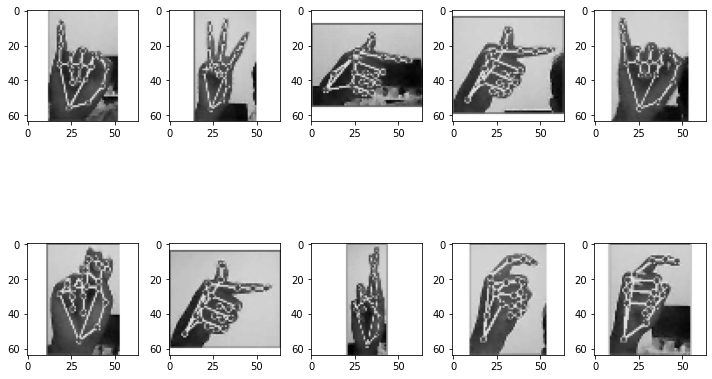

In [81]:
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(x_train[k].reshape(64, 64), cmap="gray")
        k += 1
    plt.tight_layout()


# Data Augmentation


In [82]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
)  # randomly flip images


datagen.fit(x_train)


# Training Model


In [83]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001
)


In [84]:
model = Sequential()
model.add(
    Conv2D(
        75,
        (3, 3),
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(64, 64, 1),
    )
)
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=24, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 75)        750       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 75)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 50)      

In [85]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[learning_rate_reduction],
)


Epoch 1/20
98/98 [==============================] - 74s 748ms/step - loss: 0.8372 - accuracy: 0.7373 - val_loss: 9.7252 - val_accuracy: 0.0497 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 69s 699ms/step - loss: 0.1708 - accuracy: 0.9428 - val_loss: 20.5912 - val_accuracy: 0.0414 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9666
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
98/98 [==============================] - 68s 690ms/step - loss: 0.0956 - accuracy: 0.9666 - val_loss: 26.8089 - val_accuracy: 0.0414 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 68s 690ms/step - loss: 0.0467 - accuracy: 0.9851 - val_loss: 20.1898 - val_accuracy: 0.0640 - lr: 5.0000e-04
Epoch 5/20
98/98 [==============================] - 68s 692ms/step - loss: 0.0329 - accuracy: 0.9906 - val_loss: 9.6043 - val_accuracy: 0.2031 - lr: 5.0000e-04
Epoch 6/20
98/98 [==============================] 

In [164]:
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, "%")


99/99 [==============================] - 4s 39ms/step - loss: 0.0067 - accuracy: 0.9971
Accuracy of the model is -  99.71346855163574 %


# Model Analysis


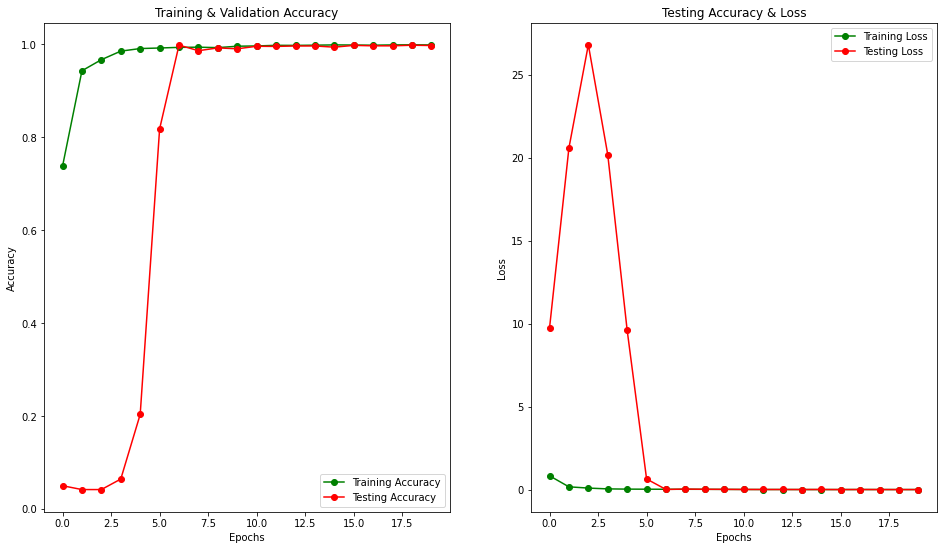

In [86]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(16, 9)

ax[0].plot(epochs, train_acc, "go-", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Testing Accuracy")
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "g-o", label="Training Loss")
ax[1].plot(epochs, val_loss, "r-o", label="Testing Loss")
ax[1].set_title("Testing Accuracy & Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [180]:
predictions = np.argmax(model.predict(x_test), axis=1)
for i in range(len(predictions)):
    predictions[i] += 1

    if predictions[i] >= 10:
        predictions[i] += 1


<IPython.core.display.Javascript object>

99/99 [==============================] - 4s 37ms/step


In [181]:
class_name = [f"Class {i}" for i in np.unique(predictions)]
print(classification_report(y, predictions, target_names=class_name))


<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

     Class 1       1.00      0.99      1.00       129
     Class 2       1.00      1.00      1.00       138
     Class 3       1.00      1.00      1.00       127
     Class 4       1.00      1.00      1.00       129
     Class 5       1.00      1.00      1.00       129
     Class 6       1.00      1.00      1.00       135
     Class 7       0.99      1.00      1.00       128
     Class 8       1.00      0.99      1.00       136
     Class 9       1.00      1.00      1.00       129
    Class 11       0.97      1.00      0.98       128
    Class 12       1.00      1.00      1.00       130
    Class 13       1.00      1.00      1.00       129
    Class 14       0.98      1.00      0.99       130
    Class 15       1.00      1.00      1.00       128
    Class 16       1.00      1.00      1.00       129
    Class 17       1.00      1.00      1.00       131
    Class 18       1.00      0.96      0.98       131
    Class 19       0.99    

In [287]:
cm = confusion_matrix(y, predictions)


In [288]:
cm = pd.DataFrame(
    cm,
    index=[i for i in range(1, 26) if i != 10],
    columns=[i for i in range(1, 26) if i != 10],
)


<AxesSubplot:>

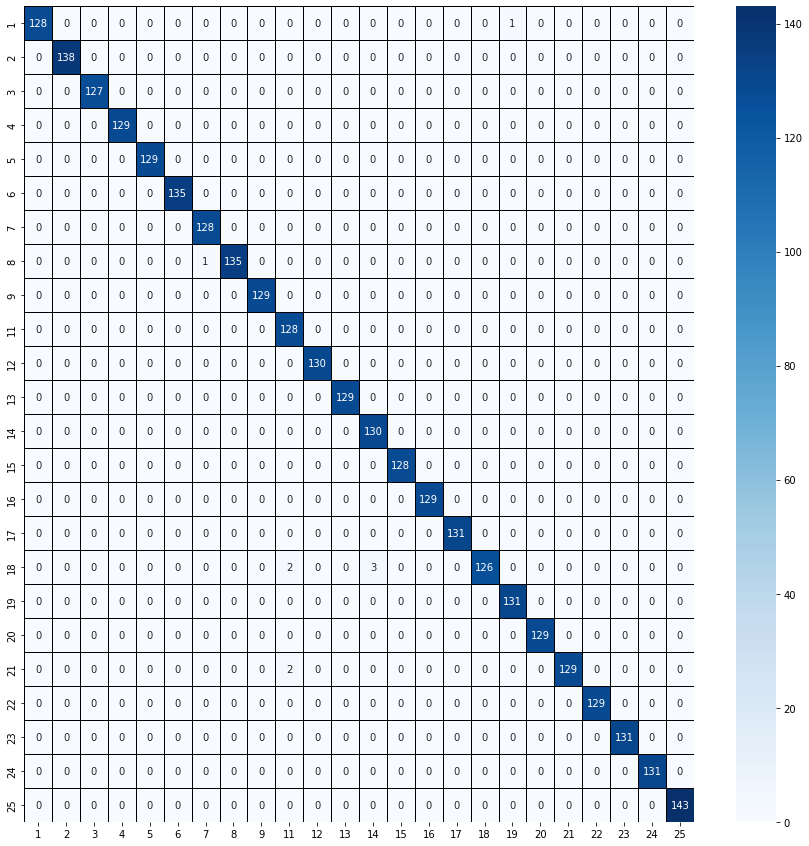

In [289]:
plt.figure(figsize=(15, 15))
sns.heatmap(cm, cmap="Blues", linecolor="black", linewidth=1, annot=True, fmt="")


# Visualize Predict Data


In [290]:
def mapper_alphabet():
    nums = [i for i in range(1, 26) if i != 10]
    alphabet = list(string.ascii_uppercase)
    alphabet.remove("J")
    alphabet.remove("Z")

    mapper = {}
    for num, alpha in zip(nums, alphabet):
        mapper[num] = alpha

    return mapper


In [291]:
df_pred_test = pd.DataFrame({"y_pred": predictions, "y_test": y})

df_pred_test["correct"] = np.where(
    df_pred_test["y_pred"] == df_pred_test["y_test"], True, False
)

df_pred_test["y_pred"] = df_pred_test["y_pred"].map(mapper_alphabet())
df_pred_test["y_test"] = df_pred_test["y_test"].map(mapper_alphabet())

shuffle(df_pred_test).head()


<IPython.core.display.Javascript object>

,y_pred,y_test,correct
1906,G,G,True
326,O,O,True
3036,M,M,True
2137,N,N,True
2244,V,V,True


## Correct


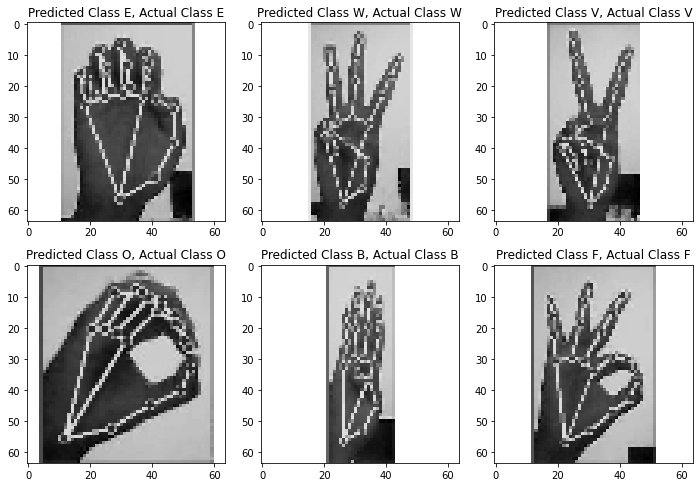

In [295]:
correct = df_pred_test.query("correct == True")

plt.figure(figsize=(10, 10))
i = 0
for c in shuffle(correct).index[:6]:
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[c].reshape(64, 64), cmap="gray", interpolation="none")
    plt.title(
        "Predicted Class {}, Actual Class {}".format(
            correct["y_pred"][c], correct["y_test"][c]
        ),
        fontsize=12,
    )
    plt.tight_layout()
    i += 1


## Not Correct


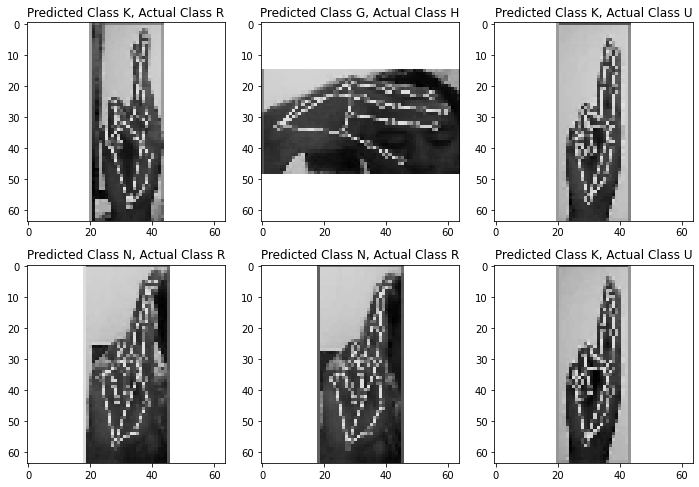

In [300]:
not_correct = df_pred_test.query("correct == False")

plt.figure(figsize=(10, 10))
i = 0
for c in shuffle(not_correct).index[:6]:
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[c].reshape(64, 64), cmap="gray", interpolation="none")
    plt.title(
        "Predicted Class {}, Actual Class {}".format(
            not_correct["y_pred"][c], not_correct["y_test"][c]
        ),
        fontsize=12,
    )
    plt.tight_layout()
    i += 1


# Thank You